# A Fully Convolutional Network for Left Ventricle Segmentation
#### by Sunghoon Park

### Introduction
In this tutorial we work with Python and the [Gluon](http://gluon.mxnet.io/) deep learning framework to instantiate a fully convolutional network (FCN) model for semantic segmentation of the left ventricle (LV) in cardiac MRI short-axis (SAX) scans. In order to enable supervised training of the FCN mdoel, we leverage the [Sunnybrook dataset](http://smial.sri.utoronto.ca/LV_Challenge/Data.html) that comes with expertly labeled ground-truth LV contours. This dataset was made publicly available as part of the Medical Image Computing and Computer Assisted Intervention (MICCAI) 2009 workshop on Cardiac MR Left Ventricle Segmentation Challenge.

In [1]:
## SET LIBRARY
import pandas as pd
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon, image
from mxnet.gluon.data import Dataset, DataLoader
from mxnet.gluon.model_zoo import vision as models
import matplotlib.pyplot as plt
%matplotlib inline
mx.random.seed(1071)

In [2]:
## SET GLOBAL
ctx = mx.cpu(0)
gtx = mx.gpu(0)

In [3]:
## SET WORK DIRETORY
work_path = '/Users/boO/data8/boo/data.student/27.cardiac_sunnybrook/Sunnybrook_Cardiac_MR_Database_DICOMPart3/TrainingDataDICOM/'

### Step 1: Load the Sunnybrook dataset
The Sunnybrook dataset consists of training images and corresponding ground truth contours used to evaluate methods for automatically segmenting LV contours from a series of MRI SAX scans in DICOM format. The dataset provides ground-truth contours for the following objects of interest: the endocardium, the epicardium, and the two largest papillary muscles. In this tutorial, we only concern ourselves with the endocardium contours of the LV, which correspond to the `i` component of the contour filename, during cardiac systole and diastole cycles.
* demonstrate cases
* preprocess DICOM image and contours`
* build data loader

In [5]:
## LOAD DATA
import os
from random import shuffle
idx_case = [case for case in os.listdir(work_path) if case[:2]=='SC']
shuffle(idx_case)

In [6]:
src = pd.DataFrame({'idx_case':[],'src_img':[],'src_lbl':[]})
for this_case in idx_case:
    id_lbl = os.listdir('/Users/boO/data8/boo/data.student/27.cardiac_sunnybrook/Sunnybrook_Cardiac_MR_Database_ContoursPart3/TrainingDataContours/%s/contours-manual/IRCCI-expert' % (this_case))
    id_lbl = [lbl.split('-')[2] for lbl in id_lbl]
    for this_lbl in id_lbl:
        chunk_img = 'Part3/TrainingDataDICOM/%s/DICOM/IM-0001-%04d.dcm' % (this_case,int(this_lbl))
        chunk_lbl = 'Part3/TrainingDataContours/%s/contours-manual/IRCCI-expert/IM-0001-%04d' % (this_case,int(this_lbl))
        src = pd.concat([src,pd.DataFrame({'idx_case':[this_case+'0'+this_lbl],'src_img':[chunk_img],'src_lbl':[chunk_lbl]})],axis=0,ignore_index=True)
print(src.shape)

(495, 3)


In [7]:
print(src['src_img'][0])
print(src['src_lbl'][0])

Part3/TrainingDataDICOM/SC-HYP-38/DICOM/IM-0001-0038.dcm
Part3/TrainingDataContours/SC-HYP-38/contours-manual/IRCCI-expert/IM-0001-0038


In [8]:
import cv2
import dicom
def load_data(src_img,src_lbl):
    img_path = '/Users/boO/data8/boo/data.student/27.cardiac_sunnybrook/Sunnybrook_Cardiac_MR_Database_DICOM%s' % (src_img)
    lbl_path = '/Users/boO/data8/boo/data.student/27.cardiac_sunnybrook/Sunnybrook_Cardiac_MR_Database_Contours%s-icontour-manual.txt' % (src_lbl)
    img = dicom.read_file(img_path)
    img = img.pixel_array.astype(np.int)
    #print(img.shape)
    one = np.loadtxt(lbl_path,delimiter=' ').astype(np.int)
    lbl = np.zeros_like(img, dtype='uint8')
    cv2.fillPoly(lbl, [one], 1)
    return img, lbl

/Users/boO/anaconda/lib/python3.6/site-packages/dicom/filereader.py:305: DeprecationWarning: generator 'data_element_generator' raised StopIteration
  raw_data_element = next(de_gen)


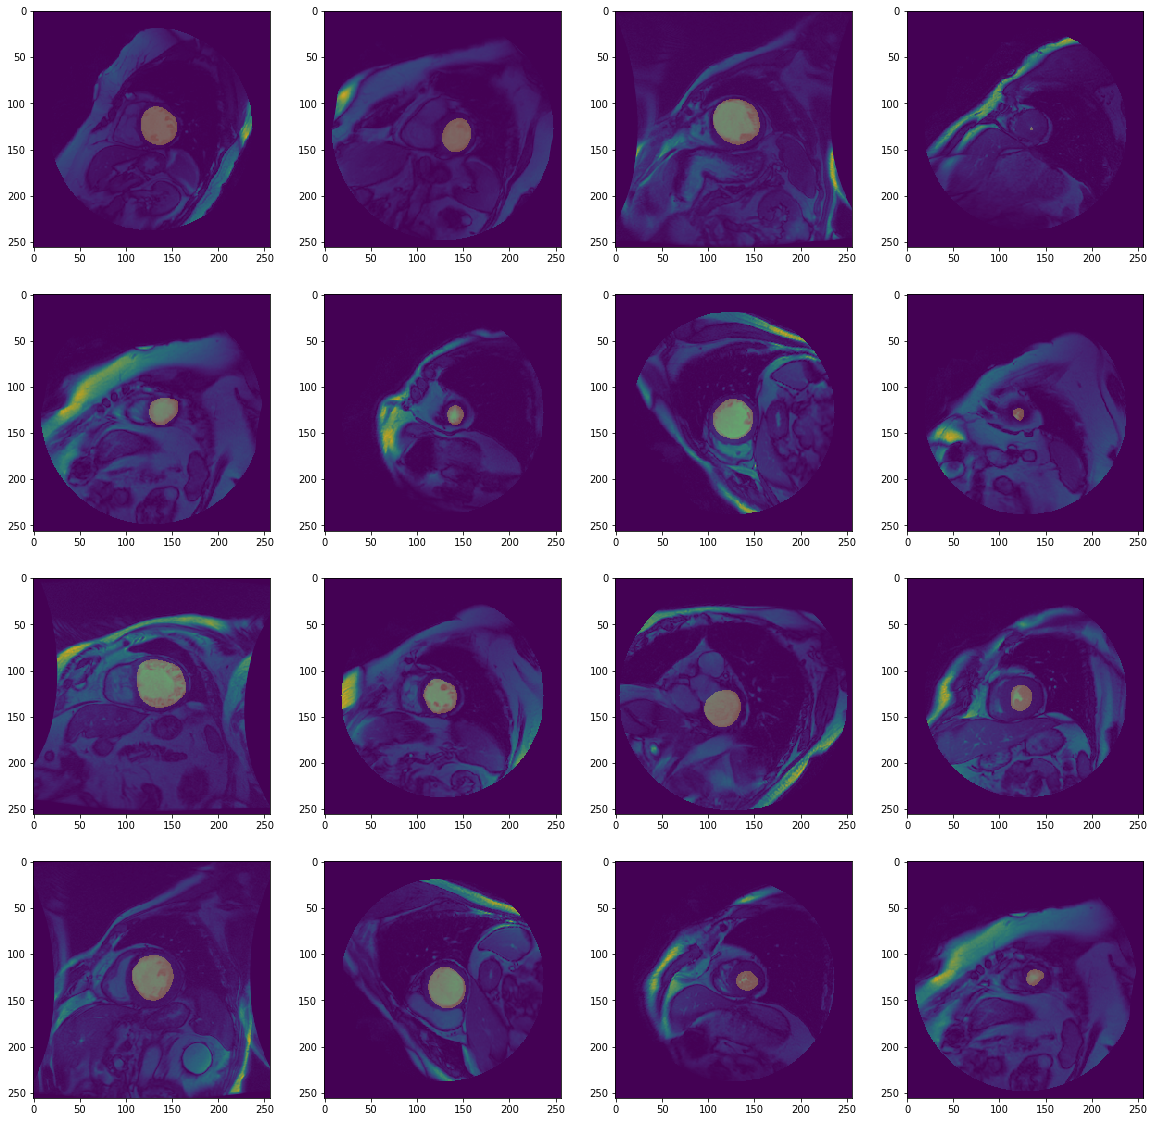

In [10]:
from random import randint
idx_case = [randint(0,src.shape[0]) for p in range(16)]
#src_img = src['src_img'][19]
#src_lbl = src['src_lbl'][19]
#img, lbl = load_data(src_img,src_lbl)

fig, ax = plt.subplots(4, 4)
plt.rcParams["figure.figsize"] = [20,20]
for e, idx in enumerate(idx_case):
    src_img = src['src_img'][idx]
    src_lbl = src['src_lbl'][idx]
    img, lbl = load_data(src_img,src_lbl)
    ax[int(e/4),e%4].imshow(img)
    ax[int(e/4),e%4].imshow(lbl,alpha=0.3)
plt.show()

In [11]:
## PREPROCESS
import cv2
import dicom
import mritopng
from matplotlib.image import imsave
from matplotlib import cm
def load_to_img(idx_case,src_img,src_lbl,idx):
    img_path = '/Users/boO/data8/boo/data.student/27.cardiac_sunnybrook/Sunnybrook_Cardiac_MR_Database_DICOM%s' % (src_img)
    split = 'valid' if idx % 10 in (8,9) else 'train'
    mritopng.convert_file(img_path,'/Users/boO/data8/boo/data.student/57.gluon/cardiac_sunnybrook/%s/img/%s-%s.png' % (split,idx_case,idx))
    
    lbl_path = '/Users/boO/data8/boo/data.student/27.cardiac_sunnybrook/Sunnybrook_Cardiac_MR_Database_Contours%s-icontour-manual.txt' % (src_lbl)
    one = np.loadtxt(lbl_path,delimiter=' ').astype(np.int)
    lbl = np.zeros_like(img, dtype='uint8')
    cv2.fillPoly(lbl, [one], 1)
    imsave('/Users/boO/data8/boo/data.student/57.gluon/cardiac_sunnybrook/%s/lbl/%s-%s.png' % (split,idx_case,idx), lbl, cmap=cm.gray)

In [38]:
from random import shuffle
idx_case = list(range(src.shape[0]))
shuffle(idx_case)

for e, idx in enumerate(idx_case):
    idx_case = src['idx_case'][idx]
    src_img = src['src_img'][idx]
    src_lbl = src['src_lbl'][idx]
    if e % 100 == 1: 
        print('%s of %s image processing job done.' % (e,src.shape[0]))
    load_to_img(idx_case,src_img,src_lbl,e)

/Users/boO/anaconda/lib/python3.6/site-packages/dicom/filereader.py:305: DeprecationWarning: generator 'data_element_generator' raised StopIteration
  raw_data_element = next(de_gen)


1 of 495 image processing job done.
101 of 495 image processing job done.
201 of 495 image processing job done.
301 of 495 image processing job done.
401 of 495 image processing job done.


In [12]:
import cv2
class DataInit(Dataset):
    def __init__(self, root, split, transform=None):
        self.root = os.path.join(root, split)
        self.transform = transform
        self.img_paths = []
        self._img = os.path.join(root, split, 'img', '{}.png')
        #self._msk = os.path.join(root, split, 'msk', '{}.png')
        self._lbl = os.path.join(root, split, 'lbl', '{}.png')
        
        for fn in os.listdir(os.path.join(root, split, 'lbl')):
            if len(fn) > 3 and fn[-4:] == '.png':
                self.img_paths.append(fn[:-4])
                
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self._img.format(self.img_paths[idx])
        lbl_path = self._lbl.format(self.img_paths[idx])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        lbl = cv2.imread(lbl_path, cv2.IMREAD_GRAYSCALE)
        
        if not self.transform is None:
            img, lbl = self.transform(img, lbl)
        return img, lbl

In [13]:
## LOAD DATA
def transform(data, label):    
    return nd.transpose(image.resize_short(mx.image.color_normalize(nd.array(data.astype(np.float32)),mean=mx.nd.array([0.485, 0.456, 0.406]),std=mx.nd.array([0.229, 0.224, 0.225])),224),(2,0,1))/255, nd.transpose(image.resize_short(nd.array(label.astype(np.uint8)[:,:,np.newaxis]),224),(2,0,1))

xy_train = DataInit('/Users/boO/data8/boo/data.student/57.gluon/cardiac_sunnybrook', 'train', transform)
xy_valid = DataInit('/Users/boO/data8/boo/data.student/57.gluon/cardiac_sunnybrook', 'valid', transform)
print(len(xy_train))
print(len(xy_valid))

397
98


In [14]:
x_input, y_label = xy_train[1]
#print(x_input.shape, y_label.shape)
print(x_input.shape)
print(y_label.shape)

(3, 224, 224)
(1, 224, 224)


In [15]:
## SET PARAMS
n_case = 397
n_output = 224 * 224

epochs = 30
btch_size = 16
n_btch = n_case / btch_size

learning_rate = 0.005

In [16]:
xy_train = gluon.data.DataLoader(xy_train,
                                 batch_size=btch_size, shuffle=True)
xy_valid = gluon.data.DataLoader(xy_valid,
                                 batch_size=btch_size, shuffle=True)

In [17]:
for i, (x_input, y_label) in enumerate(xy_train):
    x_input = x_input.as_in_context(ctx)
    y_label = y_label.as_in_context(ctx)
    print(x_input.shape)
    print(y_label.shape)
    break

(16, 3, 224, 224)
(16, 1, 224, 224)


### Step 2: Apply pre-trained Alexnet
This step shows how one can apply the Caffe FCN model trained on the Sunnybrook dataset to the DSB dataset for LV segmentation and EF calculation. This process can be considered as a form of *transfer learning*, where the task is to transfer the learned representation from one dataset to another with the goal of detecting similar representation across datasets.

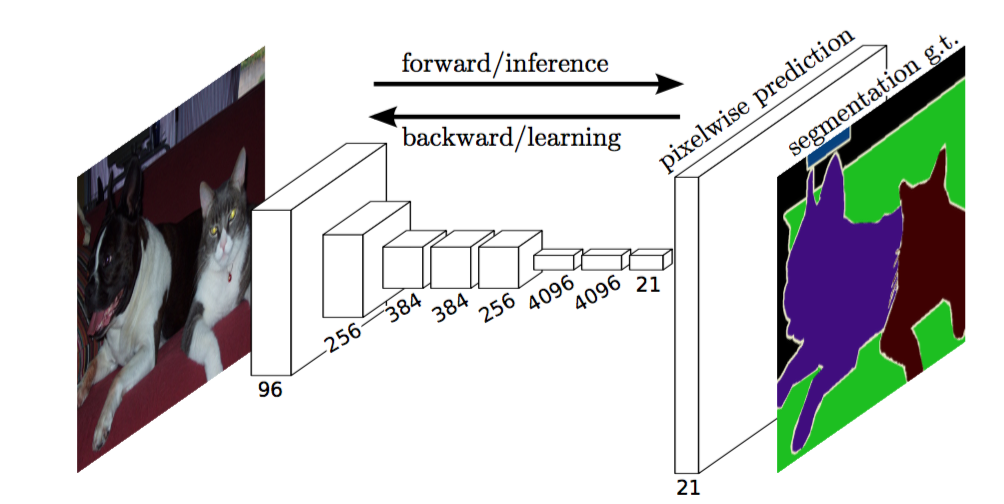

In [77]:
from IPython.display import Image
Image("/Users/boO/data8/boo/data.student/57.gluon/FCN_Alexnet.png")

In [22]:
#vgg16_base = models.vgg16(pretrained=True, root='.models', ctx=ctx)
alxnet_base = models.alexnet(pretrained=True, root='.models', ctx=ctx)

In [23]:
alxnet_base.features

HybridSequential(
  (0): Conv2D(3 -> 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(64 -> 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Conv2D(192 -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2D(384 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (8): Flatten
  (9): Dense(9216 -> 4096, Activation(relu))
  (10): Dropout(p = 0.5)
  (11): Dense(4096 -> 4096, Activation(relu))
  (12): Dropout(p = 0.5)
)

In [19]:
x_input = nd.ones((16, 3, 224, 224), ctx=ctx)
alxnet_base.features(x_input).shape

(16, 4096)

In [18]:
def ConvBlock(channels, kernel_size):
    blk = gluon.nn.HybridSequential()
    #with blk.name_scope():
    blk.add(
        gluon.nn.Conv2D(channels, kernel_size, strides=1, padding=0, groups=1),
        gluon.nn.BatchNorm(),
        gluon.nn.Activation('relu')
    )
    return blk

In [ ]:
class GPH(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(GPH, self).__init__(**kwargs)
        with self.name_scope():
            self.alxnet = models.alexnet(pretrained=True, root='.models', ctx=ctx).features
            self.classifier = gluon.nn.HybridSequential()
            with self.classifier.name_scope():
                self.classifier.add(ConvBlock(channels=4096, kernel_size=6))
                self.classifier.add(ConvBlock(channels=4096, kernel_size=1))
                self.classifier.add(gluon.nn.Conv2DTranspose(channels=2, kernel_size=224, padding=0,strides=32, use_bias=False))
                
    def hybrid_forward(self, F, x):
        x = self.alxnet[0](x)
        x = self.alxnet[1](x)
        x = self.alxnet[2](x)
        x = self.alxnet[3](x)
        x = self.alxnet[4](x)
        x = self.alxnet[5](x)
        x = self.alxnet[6](x)
        x = self.alxnet[7](x)
        x = self.classifier(x)
        return x
    
gph = GPH()
gph.alxnet.collect_params().setattr('grad_req', 'null')
gph.classifier.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
#gph.collect_params().reset_ctx(ctx)
print(gph)

In [20]:
x_input = nd.ones((16, 3, 224, 224), ctx=ctx)
print(gph(x_input).shape)

(16, 2, 224, 224)


In [42]:
## SANDBOX
for i, (x_input, y_label) in enumerate(xy_train):
    break
    x_input = x_input.as_in_context(ctx)
    y_label = y_label.as_in_context(ctx)
output = gph(x_input)
print(y_label.shape)
print(output.shape)
print(cross_entropy(output, y_label))

y_pred = nd.argmax(output, axis=1, keepdims=True)
acc = mx.metric.Accuracy()
acc.update(preds=y_pred, labels=y_label)
print(acc)

(16, 1, 224, 224)
(16, 2, 224, 224)

[ 0.69315976  0.69315207  0.69315976  0.69315624  0.6931504   0.69315511
  0.69315559  0.69315058  0.69316     0.69316024  0.69316143  0.69315726
  0.69315612  0.69315928  0.69314963  0.69315577]
<NDArray 16 @cpu(0)>
EvalMetric: {'accuracy': 0.48649877431441324}


In [21]:
cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)
optimizer = gluon.Trainer(gph.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd': 0.001})

In [22]:
def softmax(output):
    exp = nd.exp(output - nd.max(output, axis=1, keepdims=True))
    norms = nd.sum(exp, axis=1, keepdims=True)
    return exp / norms

def evaluator(data_iterator, gph, loss_func):
    acc = mx.metric.Accuracy()
    loss_avg = 0.
    for i, (x_input, y_label) in enumerate(data_iterator):
        x_input = x_input.as_in_context(ctx)
        #x_input = nd.tile(x_input,(1,3,1,1))
        #x_input = mx.image.color_normalize(x_input,
        #                                   mean=mx.nd.array([0.485, 0.456, 0.406]),
        #                                   std=mx.nd.array([0.229, 0.224, 0.225]))
        y_label = y_label.as_in_context(ctx)
        output = gph(x_input)
        loss = loss_func(output, y_label)
        y_pred = nd.argmax(output, axis=1, keepdims=True)
        acc.update(preds=y_pred, labels=y_label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return acc.get()[1], loss_avg

def plot_mets(loss_tr,loss_ts, acc_tr, acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

[0th epoch] Loss :  0.692747
[0th epoch] Train ACC :  0.588092
[0th epoch] Test  ACC :  0.588753
[1th epoch] Loss :  0.389212
[1th epoch] Train ACC :  0.680304
[1th epoch] Test  ACC :  0.680516
[2th epoch] Loss :  0.290056
[2th epoch] Train ACC :  0.760873
[2th epoch] Test  ACC :  0.760741
[3th epoch] Loss :  0.241941
[3th epoch] Train ACC :  0.826993
[3th epoch] Test  ACC :  0.826850
[4th epoch] Loss :  0.214188
[4th epoch] Train ACC :  0.877602
[4th epoch] Test  ACC :  0.877494
[5th epoch] Loss :  0.196559
[5th epoch] Train ACC :  0.913744
[5th epoch] Test  ACC :  0.913853
[6th epoch] Loss :  0.184663
[6th epoch] Train ACC :  0.938248
[6th epoch] Test  ACC :  0.938728
[7th epoch] Loss :  0.176301
[7th epoch] Train ACC :  0.953673
[7th epoch] Test  ACC :  0.954257
[8th epoch] Loss :  0.170247
[8th epoch] Train ACC :  0.962836
[8th epoch] Test  ACC :  0.963555
[9th epoch] Loss :  0.165768
[9th epoch] Train ACC :  0.967920
[9th epoch] Test  ACC :  0.968721
[10th epoch] Loss :  0.162396


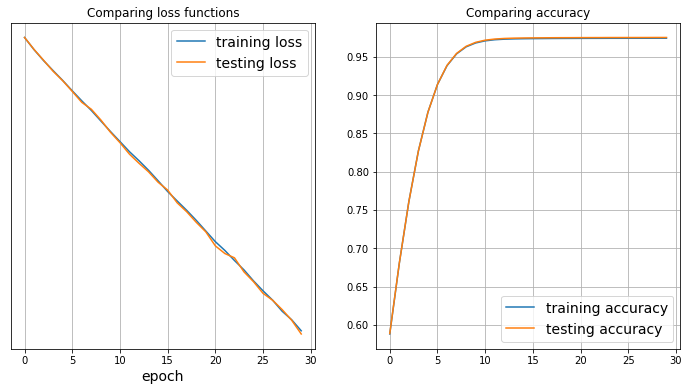

In [23]:
idx_mets = pd.DataFrame({'loss_tr':[],'loss_ts':[],'acc_tr':[],'acc_ts':[]})
n_iter = 0
for epoch in range(epochs):
    mov_loss = 0
    for i, (x_input, y_label) in enumerate(xy_train):
        x_input = x_input.as_in_context(ctx)
        #x_input = nd.tile(x_input,(1,3,1,1))
        y_label = y_label.as_in_context(ctx)
        #y_label = nd.one_hot(y_label, n_output)
        with autograd.record(train_mode=True):
            output = gph(x_input)
            loss = cross_entropy(output, y_label)
        loss.backward()
        optimizer.step(btch_size)
        n_iter +=1
        mov_loss = .99 * mov_loss + .01 * nd.mean(loss).asscalar()
        est_loss = mov_loss/(1-0.99**n_iter)
        
    print("[%sth epoch] Loss :  %0.6f" % (epoch, est_loss))
    acc_train, loss_train = evaluator(xy_train, gph, cross_entropy)
    acc_test, loss_test = evaluator(xy_valid, gph, cross_entropy)
    print("[%sth epoch] Train ACC :  %0.6f" % (epoch, acc_train))
    print("[%sth epoch] Test  ACC :  %0.6f" % (epoch, acc_test))
    idx_mets = pd.concat([idx_mets,pd.DataFrame({'loss_tr':[loss_train],'loss_ts':[loss_test],'acc_tr':[acc_train],'acc_ts':[acc_test]})],axis=0,ignore_index=True)
    
plot_mets(idx_mets['loss_tr'],idx_mets['loss_ts'],idx_mets['acc_tr'],idx_mets['acc_ts'])

### Step 3: Evaluate the performance
* [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)

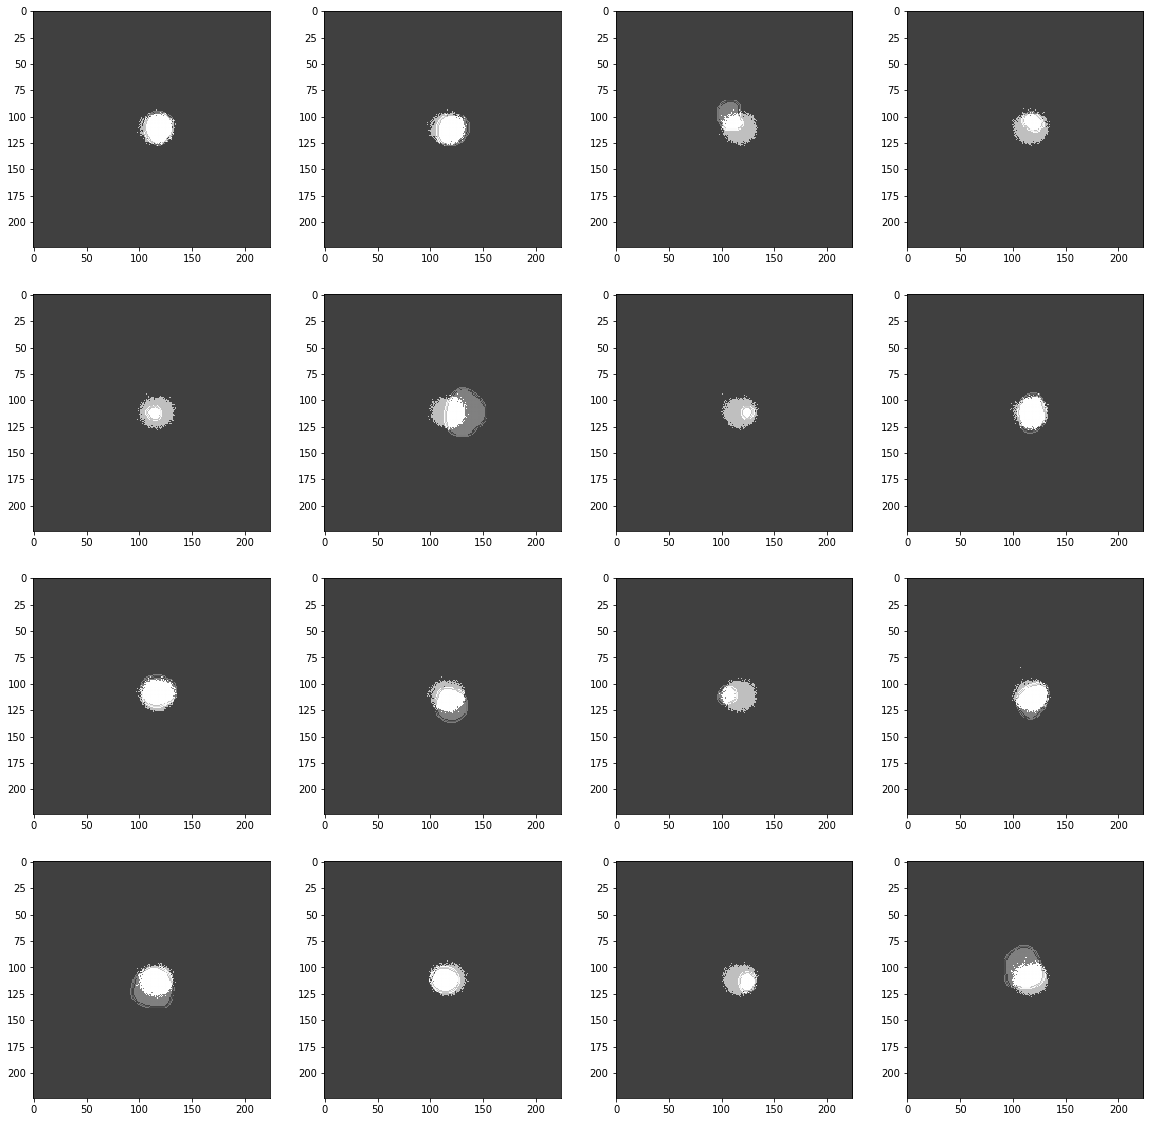

In [24]:
def predictor(gph, x_input):
    with autograd.predict_mode():
        output = gph(x_input)
        return nd.argmax(output, axis=1, keepdims=True)

xy_sample = DataInit('/Users/boO/data8/boo/data.student/57.gluon/cardiac_sunnybrook', 'valid', transform)
xy_sample = gluon.data.DataLoader(xy_sample, batch_size=16, shuffle=True)
for i, (x_input, y_label) in enumerate(xy_sample):
    x_input = x_input.as_in_context(ctx)
    y_label = y_label.as_in_context(ctx)
    y_label = nd.tile(y_label,(1,3,1,1))
    y_label = y_label.astype('uint8')
    y_pred = predictor(gph,x_input)
    y_pred = nd.tile(y_pred,(1,3,1,1))
    break

fig, ax = plt.subplots(4, 4)
plt.rcParams["figure.figsize"] = [20,20]
for i in range(16):
    obs = nd.transpose(y_label[i],(1,2,0))
    prd = nd.transpose(y_pred[i],(1,2,0))

    ax[int(i/4),i%4].imshow(obs.asnumpy(),alpha=0.5)
    ax[int(i/4),i%4].imshow(prd.asnumpy(),alpha=0.5)
plt.show()

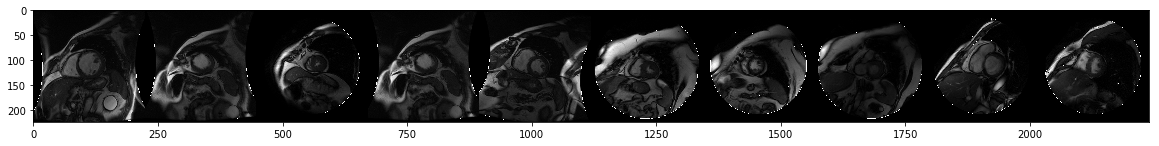

In [30]:
def viewer(data, label):    
    return nd.transpose(image.resize_short(nd.array(data.astype(np.float32)),224),(2,0,1)), nd.transpose(image.resize_short(nd.array(label.astype(np.uint8)[:,:,np.newaxis]),224),(2,0,1))
xy_sample = DataInit('/Users/boO/data8/boo/data.student/57.gluon/cardiac_sunnybrook', 'train', viewer)
xy_sample = gluon.data.DataLoader(xy_sample, 10, shuffle=True)
for i, (x_input, y_label) in enumerate(xy_sample):
    x_input = x_input.as_in_context(ctx)
    x_input = x_input.astype('uint8')
    im = nd.transpose(x_input,(2,0,3,1))
    im = nd.reshape(im,(224,10*224,3))
    plt.imshow(im.asnumpy())
    plt.show()
    break    

In [323]:
## SAVE PARAMS
gph.save_params('FCN.params')
!ls
#net2 = gluon.nn.Sequential()
#with net2.name_scope():
#    net2.add(gluon.nn.Dense(num_hidden, activation="relu"))
#    net2.add(gluon.nn.Dense(num_hidden, activation="relu"))
#    net2.add(gluon.nn.Dense(num_output))
#net2.load_params(filename, ctx=ctx)
#net2(nd.ones((1, 100), ctx=ctx))

CNN_gluon.ipynb
FCN.params
FCN_Alexnet.ipynb
FCN_Tutorial.ipynb
FCN_gluon.ipynb
LinearRegression.ipynb
LinearRegression_L2.ipynb
LinearRegression_gluon.ipynb
LogisticRegression_gluon.ipynb
MulticlassRegression.ipynb
MulticlassRegressionL2_gluon.ipynb
RNN.ipynb
VGG16_gluon.ipynb
[180122] 박성훈 FCN-Alexnet using Gluon.ipynb
cardiac_sunnybrook
im2rec.py
timemachine.txt


### Step 4: To-Dos
* im2rec를 이용한 이미지 처리 및 데이터 로더 구현
* 해석 모형 추가?

### Reference
* [NVIDIA DLI](https://github.com/NVIDIA/DIGITS/tree/master/examples/medical-imaging)